In [1]:
# Imports
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
device = torch.device('cuda')

from layer_importance.evaluate import test_network
from layer_importance.prune import prune_network

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

In [ ]:
# Train baseline VGG16 model for 50 epochs on CIFAR-10 dataset

In [3]:
!python -Wi -m layer_importance.main \
--train-flag \
--epoch 50 \
--data-set CIFAR10 \
--vgg vgg16 \
--save-path ./trained_models/

-*--*--*--*--*--*--*--*--*--*-
	Arguments
-*--*--*--*--*--*--*--*--*--*-
gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16
start_epoch: 0
epoch: 50
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Train network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:07:19 2022: Epoch [0], Iteration [0/391/], Data(s): 0.040, Loss(s): 0.003, Forward(s): 0.178, Backward(s): 0.188, Top1: 7.812, Top5: 44.5312, Loss: 2.528
Fri Dec 16 04:07:24 2022: Epoch [0], Iteration [100/391/], Data(s): 0.035, Loss(s): 0.003, Forward(s): 0.004, Backward(s): 0.006, Top1: 14.148, Top5: 59.4988, 

In [4]:
print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")

Original Model Size = 57.3 MB


In [5]:
# View created args 
load_path = 'trained_models/'
args = torch.load(load_path+'arguments.pth')

for key, value in vars(args).items():
    print("%s: %s"%(key, value))

#################################
args.load_path = load_path + 'check_point.pth'
args.save_path = load_path+'%s/'%time.ctime().replace(' ', '_')
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

gpu_no: 0
train_flag: True
resume_flag: False
prune_flag: False
retrain_flag: False
retrain_epoch: 20
retrain_lr: 0.001
data_set: CIFAR10
data_path: ../
vgg: vgg16
start_epoch: 0
epoch: 50
batch_size: 128
num_workers: 2
lr: 0.1
lr_milestone: [150, 250]
lr_gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
imsize: None
cropsize: 32
crop_padding: 4
hflip: 0.5
print_freq: 100
load_path: None
save_path: ./trained_models/
independent_prune_flag: False
prune_layers: None
prune_channels: None


In [6]:
# Evaluate baseline model on test data
network, test_set, (top1, top5) = test_network(args)

Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:24:55 2022: Test information, Data(s): 1.626, Forward(s): 0.238, Top1: 73.270, Top5: 96.460, 


In [7]:
# Evaluate baseline model size and params

print(f"Original Model Size = {os.path.getsize('trained_models/check_point.pth') / (1024 * 1024) :.1f} MB")
params = sum([np.prod(p.size()) for p in network.parameters()])
print("Original Number of Parameters: %.1fM"%(params/1e6))

Original Model Size = 57.3 MB
Original Number of Parameters: 15.0M


In [8]:
colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
lines = ['-', '--', '-.']

In [ ]:
# Analyze layers based on absolute magnitude of filter weights

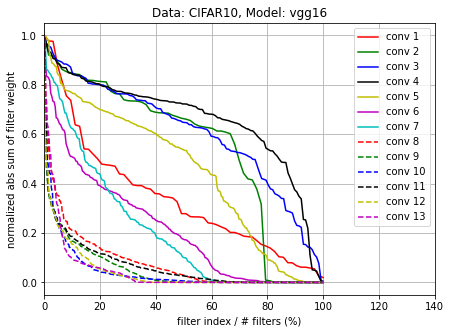

In [9]:
plt.figure(figsize=(7,5))
conv_count = 0
fw_list = []

for layer in network.features:
    if isinstance(layer, torch.nn.Conv2d):
        line_style = colors[conv_count%len(colors)] + lines[conv_count//len(colors)]
        
        # filter weight dimension info: out_ch, in_ch, k1, k2
        fw = layer.weight.data.cpu().numpy()
        fw_list.append(fw)
        
        # sort descending order
        sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
        
        # normalize with maximum value
        normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
        conv_count += 1
        plt.plot(np.linspace(0, 100, normalized_abs_sum.shape[0]), normalized_abs_sum, line_style, label='conv %d'%conv_count)
        
plt.title("Data: %s, Model: %s"%(args.data_set, args.vgg))        
plt.ylabel("normalized abs sum of filter weight")
plt.xlabel("filter index / # filters (%)")
plt.legend(loc='upper right')
plt.xlim([0, 140])
plt.grid()
plt.savefig("figure1.png", dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Evaluate normalized sum of layer weights
for i, fw in enumerate(fw_list):
    # print(f'Conv{i+1} total sum = {np.sum(np.abs(fw.reshape(fw.shape[0], -1))):.3f}')
    sorted_abs_sum = np.sort(np.sum(np.abs(fw.reshape(fw.shape[0], -1)), axis=1))[::-1]
    normalized_abs_sum = sorted_abs_sum/sorted_abs_sum[0]
    print(f'Conv{i+1} Normalized sum = {np.sum(normalized_abs_sum):.3f}')
    print()

Conv1 Normalized sum = 22.103

Conv2 Normalized sum = 34.979

Conv3 Normalized sum = 77.347

Conv4 Normalized sum = 84.274

Conv5 Normalized sum = 115.476

Conv6 Normalized sum = 55.815

Conv7 Normalized sum = 53.225

Conv8 Normalized sum = 42.013

Conv9 Normalized sum = 27.635

Conv10 Normalized sum = 23.271

Conv11 Normalized sum = 34.697

Conv12 Normalized sum = 22.369

Conv13 Normalized sum = 24.328



In [11]:
# Check model structure before pruning
print('--- Before Pruning ---')
print(network)

--- Before Pruning ---
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

In [12]:
# Define sequential model pruning approach: Prune 10% of filters of each layer iteratively upto max 90%

prune_step_ratio = 1/8
max_channel_ratio = 0.90 

prune_channels = [64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512]
prune_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 
                'conv8', 'conv9', 'conv10', 'conv11', 'conv12', 'conv13']

In [14]:
# Prune model iteratively without finetuning and check layer importance

top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

# Consider each conv layer one by one
for conv, channel in zip(prune_layers, prune_channels):
    print(f'============== Working with layer {conv} ==============')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    # Prune 10% of filters in each step
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information and prune network
        args.prune_layers = [conv]
        args.prune_channels = [steps[i]]
        network = prune_network(args, network)
        
        # evaluate network on test data after pruning
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
        
    # Save evaluation metrics
    print('============================')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))
    print('============================')


============== Working with layer conv1 ==============
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:25:00 2022: Test information, Data(s): 1.689, Forward(s): 0.201, Top1: 73.270, Top5: 96.460, 

Fri Dec 16 04:25:00 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:25:03 2022: Test information, Data(s): 2.439, Forward(s): 0.279, Top1: 73.380, Top5: 96.470, 

Fri Dec 16 04:25:03 2022: conv1 Layer, 16 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:25:06 2022: Test information, Data(s): 1.927, Forward(s): 0.253, Top1: 73.540, Top5: 96.530, 

Fri Dec 16 04:25:06 2022: conv1 Layer, 24 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*

In [16]:
model_params

defaultdict(list,
            {'conv1': [14.94907],
             'conv2': [14.884945],
             'conv3': [14.784663],
             'conv4': [14.585943],
             'conv5': [14.188388],
             'conv6': [13.923428],
             'conv7': [13.393508],
             'conv8': [11.803518],
             'conv9': [10.743678],
             'conv10': [10.743678],
             'conv11': [10.743678],
             'conv12': [10.743678],
             'conv13': [12.627838]})

In [ ]:
# Check layer importance based on iterative pruning without finetuning

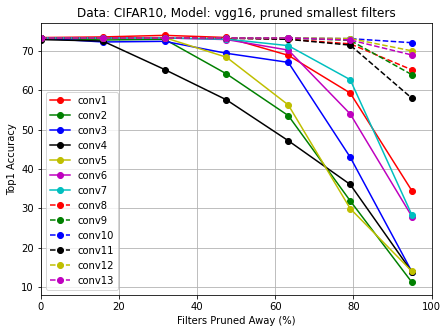

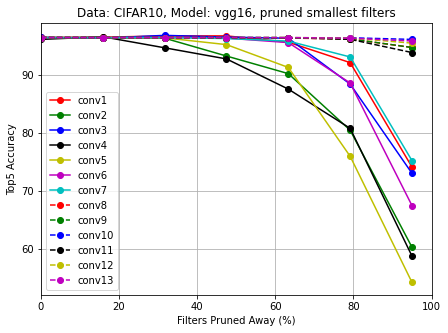

In [17]:
plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(7,5))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters"%(args.data_set, args.vgg))        
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure2_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [ ]:
# Repeat above process but also do finetuning (retraining with small LR) after pruning at each step

In [18]:
args.retrain_flag = True
args.retrain_epoch = 3
args.independent_prune_flag = False
args.retrain_lr = 0.001

In [19]:
# Prune model iteratively with finetuning and check layer importance

top1_accuracies = {}
top5_accuracies = {}
model_size = defaultdict(list)
model_params = defaultdict(list)

# Consider each conv layer one by one
for conv, channel in zip(prune_layers, prune_channels):
    print(f'============== Working with layer {conv} ==============')
    top1_accuracies[conv] = []
    top5_accuracies[conv] = []
    
    # load new network and check accuracy
    network, _, _ = test_network(args, data_set=test_set)
        
    # remove 0 channels ~ M (max_channel_ratio) % of total channels
    step = np.linspace(0, int(channel*max_channel_ratio), int(1/prune_step_ratio), dtype=np.int)
    steps = (step[1:] - step[:-1]).tolist()
    
    # Prune 10% of filters in each step
    for i in range(len(steps)):
        print("\n%s: %s Layer, %d Channels pruned"%(time.ctime(), conv, sum(steps[:i+1])))
        
        # set prune information and prune network
        args.prune_layers = [conv]
        args.prune_channels = [steps[i]]
        network = prune_network(args, network)
        
        # evaluate network on test data after pruning
        network, _, (top1, top5) = test_network(args, network, test_set)
            
        top1_accuracies[conv].append(top1)
        top5_accuracies[conv].append(top5)
    
    # Save evaluation metrics
    print('============================ ')
    size = os.path.getsize('trained_models/check_point_pruned.pth') / (1024 * 1024)
    print(f"Model Size = {size:.1f} MB")
    model_size[conv].append(size)

    params = sum([np.prod(p.size()) for p in network.parameters()])/1e6
    model_params[conv].append(params)
    print("Number of Parameters: %.1fM"%(params))
    print('============================ ')


============== Working with layer conv1 ==============
-*--*--*--*--*--*--*--*--*--*- Evaluate network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:29:54 2022: Test information, Data(s): 1.685, Forward(s): 0.195, Top1: 73.270, Top5: 96.460, 

Fri Dec 16 04:29:54 2022: conv1 Layer, 8 Channels pruned
-*--*--*--*--*--*--*--*--*--*- Prune network -*--*--*--*--*--*--*--*--*--*-
Files already downloaded and verified
-*--*--*--*--*--*--*--*--*--*- Train network -*--*--*--*--*--*--*--*--*--*-
Fri Dec 16 04:29:55 2022: Epoch [0], Iteration [0/391/], Data(s): 0.041, Loss(s): 0.000, Forward(s): 0.142, Backward(s): 0.200, Top1: 83.594, Top5: 98.4375, Loss: 0.556
Fri Dec 16 04:30:00 2022: Epoch [0], Iteration [100/391/], Data(s): 0.035, Loss(s): 0.002, Forward(s): 0.004, Backward(s): 0.007, Top1: 83.284, Top5: 98.6154, Loss: 0.523
Fri Dec 16 04:30:07 2022: Epoch [0], Iteration [200/391/], Data(s): 0.040, Loss(s): 0.002, Forward(s): 0.003, Backward(s): 0.006, Top1: 84.021, Top5: 98.7251, Loss: 0.475

In [ ]:
# Check layer importance based on iterative pruning with finetuning

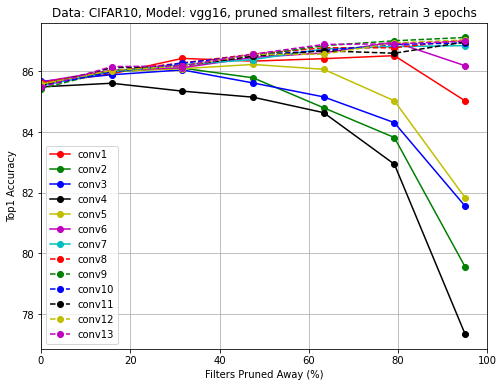

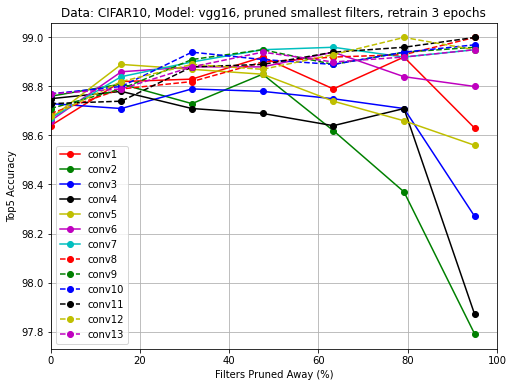

In [20]:
plt.figure(figsize=(8,6))
for index, (key, value) in enumerate(top1_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top1 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top1.png", dpi=150, bbox_inches='tight')
plt.show()                

plt.figure(figsize=(8,6))
for index, (key, value) in enumerate(top5_accuracies.items()):
    line_style = colors[index%len(colors)] + lines[index//len(colors)] +'o'
    plt.plot(np.linspace(0, 95, len(value)), value, line_style, label=key)

plt.title("Data: %s, Model: %s, pruned smallest filters, retrain %d epochs"%(args.data_set, args.vgg, args.retrain_epoch))
plt.ylabel("Top5 Accuracy")
plt.xlabel("Filters Pruned Away (%)")
plt.legend(loc='lower left')
plt.grid()
plt.xlim(0, 100)
plt.savefig("figure3_top5.png", dpi=150, bbox_inches='tight')
plt.show()                


In [22]:
model_params

defaultdict(list,
            {'conv1': [14.94907],
             'conv2': [14.884945],
             'conv3': [14.784663],
             'conv4': [14.585943],
             'conv5': [14.188388],
             'conv6': [13.923428],
             'conv7': [13.393508],
             'conv8': [11.803518],
             'conv9': [10.743678],
             'conv10': [10.743678],
             'conv11': [10.743678],
             'conv12': [10.743678],
             'conv13': [12.627838]})

In [23]:
 model_params.values()

dict_values([[14.94907], [14.884945], [14.784663], [14.585943], [14.188388], [13.923428], [13.393508], [11.803518], [10.743678], [10.743678], [10.743678], [10.743678], [12.627838]])

In [ ]:
# Plot progression of MACs with iterative pruning rounds

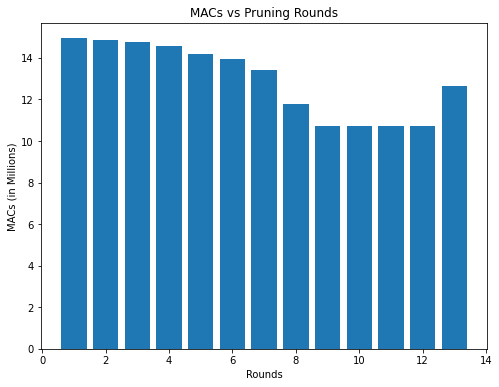

In [24]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 14), [a[0] for a in list(model_params.values())])
plt.xlabel('Rounds')
plt.ylabel('MACs (in Millions)')
plt.title('MACs vs Pruning Rounds')
plt.show()